In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
import yfinance as yf

In [ ]:
data = yf.download("AAPL", start="2010-01-01", end="2019-12-31")
data = data.reset_index()
data = data[['Close']]

/tmp/ipython-input-1268816972.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2010-01-01", end="2019-12-31")
[*********************100%***********************]  1 of 1 completed


In [ ]:
price_scaler = MinMaxScaler(feature_range=(0,1))
scaled_close = price_scaler.fit_transform(data[['Close']])

In [ ]:
train_size = int(len(scaled_close)*0.8)
train_data = scaled_close[:train_size]
test_data = scaled_close[train_size - 100:]

In [ ]:
window=100
x_train, y_train = [], []
for i in range(window, len(train_data)):
    x_train.append(train_data[i-window:i, 0])
    y_train.append(train_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)

In [ ]:
model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(window,1)),
    BatchNormalization(),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=100, batch_size=16)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0469
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0020
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0020
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 9.8493e-04
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.7059e-04
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.8372e-04
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5.4425e-04
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.0569e-04
Epoch 9/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 6.8792e-04
Epoch 10/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 4.3154e-04
Epoch 11/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5.2109e-04
Epoch 12/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5.2828e-04
Epoch 13/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.6082e-04
Epoch 14/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.1124e-

In [ ]:
x_test, y_test = [], []
for i in range(window, len(test_data)):
    x_test.append(test_data[i-window:i,0])
    y_test.append(test_data[i,0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],1)
y_test = np.array(y_test).reshape(-1,1)

In [ ]:
y_predicted = model.predict(x_test).reshape(-1,1)
y_predicted = price_scaler.inverse_transform(y_predicted)
y_test = price_scaler.inverse_transform(y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_predicted))
print("RMSE:", rmse)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
RMSE: 3.523062782828186


In [ ]:
future = 7
last_window = test_data[-window:].reshape(window,1)
future_predictions = []
for _ in range(future):
    x = last_window.reshape(1,window,1)
    pred = model.predict(x)
    pred_value = float(pred)
    future_predictions.append(pred_value)
    last_window = np.vstack([last_window[1:], [[pred_value]]])
future_predictions = np.array(future_predictions).reshape(-1,1)
future_predictions = price_scaler.inverse_transform(future_predictions)

/tmp/ipython-input-332913113.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_value = float(pred)


In [ ]:
residuals = y_test.flatten() - y_predicted.flatten()
std = np.std(residuals)
upper = future_predictions.flatten() + 1.96*std
lower = future_predictions.flatten() - 1.96*std

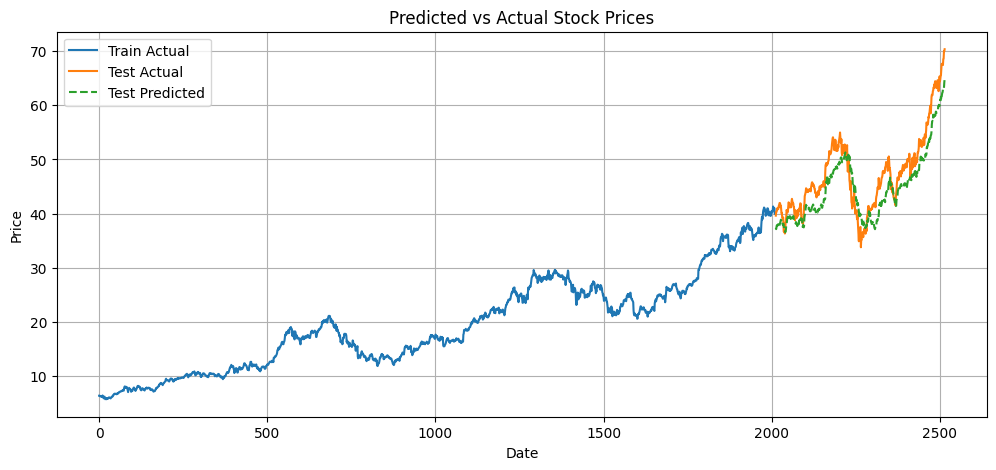

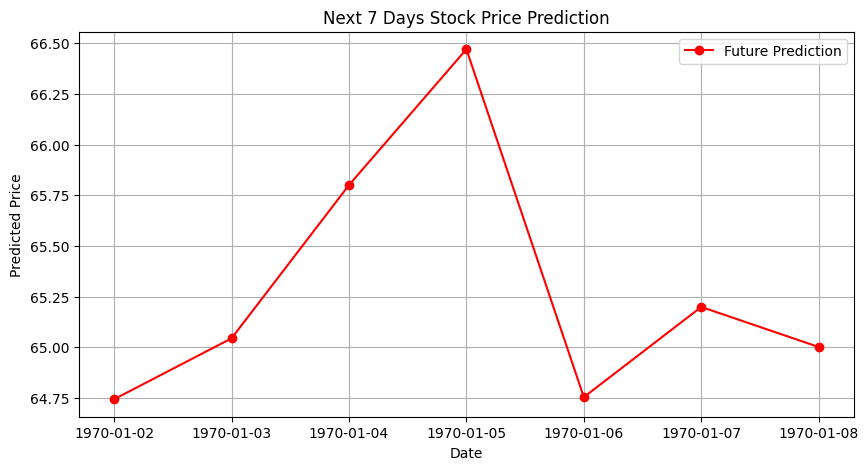

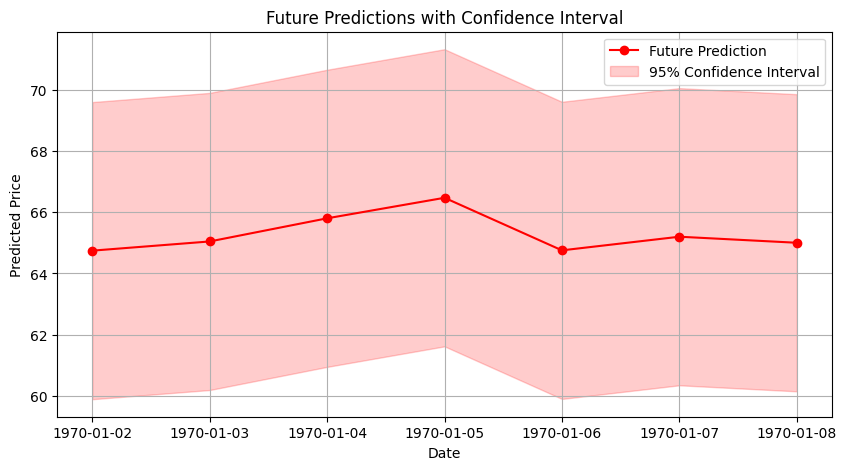

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(data.index[:train_size], price_scaler.inverse_transform(scaled_close[:train_size]), label="Train Actual")
plt.plot(data.index[train_size:], y_test, label="Test Actual")
plt.plot(data.index[train_size:], y_predicted, label="Test Predicted", linestyle='--')
plt.title("Predicted vs Actual Stock Prices")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend(); plt.grid(True); plt.show()

future_dates = pd.date_range(start=data.index[-1], periods=future_days+1)[1:]
plt.figure(figsize=(10,5))
plt.plot(future_dates, future_predictions, label="Future Prediction", color='red', marker='o')
plt.title("Next 7 Days Stock Price Prediction")
plt.xlabel("Date"); plt.ylabel("Predicted Price")
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(10,5))
plt.plot(future_dates, future_predictions, label="Future Prediction", color='red', marker='o')
plt.fill_between(future_dates, lower, upper, color='red', alpha=0.2, label="Confidence Interval")
plt.title("Future Predictions with Confidence Interval")
plt.xlabel("Date"); plt.ylabel("Predicted Price")
plt.grid(True); plt.legend(); plt.show()